In [233]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
from rosbags.highlevel import AnyReader

import numpy as np

In [234]:
def get_pose_data(bag_path, topic_name):
    poses_data = {
        'timestamp': [],
        'time_sec': [],
        'position_x': [],
        'position_y': [],
        'position_z': [],
        'orientation_x': [],
        'orientation_y': [],
        'orientation_z': [],
        'orientation_w': []
    }

    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)

            # Extract pose data
            poses_data['timestamp'].append(timestamp)
            poses_data['time_sec'].append(timestamp / 1e9)

            poses_data['position_x'].append(msg.position.x)
            poses_data['position_y'].append(msg.position.y)
            poses_data['position_z'].append(msg.position.z)

            poses_data['orientation_x'].append(msg.orientation.x)
            poses_data['orientation_y'].append(msg.orientation.y)
            poses_data['orientation_z'].append(msg.orientation.z)
            poses_data['orientation_w'].append(msg.orientation.w)

    poses_data = pd.DataFrame(poses_data)
    
    # clean up time_sec
    poses_data['time_sec'] = poses_data['time_sec'] - poses_data['time_sec'].min()
    return poses_data

def get_cmd_vel_data(bag_path, topic_name):
    cmd_vel_data = {
        'timestamp': [],
        'time_sec': [],
        'linear_x': [],
        'angular_z': []
    }

    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)

            # Extract pose data
            cmd_vel_data['timestamp'].append(timestamp)
            cmd_vel_data['time_sec'].append(timestamp / 1e9)
            cmd_vel_data['linear_x'].append(msg.linear.x)
            cmd_vel_data['angular_z'].append(msg.angular.z)

    cmd_vel_data = pd.DataFrame(cmd_vel_data)

    # clean up time_sec
    cmd_vel_data['time_sec'] = cmd_vel_data['time_sec'] - cmd_vel_data['time_sec'].min()

    return cmd_vel_data

def get_force_data(bag_path, topic_name):
    force_data = {
        'timestamp': [],
        'time_sec': [],
        'data': []
    }
    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)
            force_data['timestamp'].append(timestamp)
            force_data['time_sec'].append(timestamp / 1e9)
            force_data['data'].append(msg.data)

    force_data = pd.DataFrame(force_data)

    # clean up time_sec
    force_data['time_sec'] = force_data['time_sec'] - force_data['time_sec'].min()

    return force_data


def plot_displacements_over_time(timestamps, monica_poses, ross_poses):
    displacements = np.abs(monica_poses['position_x'].values - ross_poses['position_x'].values)

    plt.plot(
        timestamps,
        displacements,
        '-r'
    )
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('Displacement over time for monica and ross')
    plt.show()

def plot_forces(timestamps, monica_force_data, ross_force_data):
    plt.plot(
        timestamps,
        monica_force_data,
        '-r'
    )
    plt.plot(
        timestamps,
        ross_force_data,
        '-b'
    )
    plt.legend(['monica', 'ross'])
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('force (N)')
    plt.title('Force readings over time')
    plt.show()

def plot_force_data(timestamps, force_data):
    plt.plot(
        timestamps,
        force_data,
        '-b'
    )
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('force (N)')
    plt.title('Force readings over time')
    plt.show()


def clean_data(monica_data, ross_data, monica_cmd_vel_data, ross_cmd_vel_data):
    # extract the time the robots started moving and then stopped
    # monica_cmd_vel_data.drop(monica_cmd_vel_data[monica_cmd_vel_data['linear_x'] == 0].index,
    #     inplace=True)
    # monica_cmd_vel_data.reset_index(inplace=True)
    # ross_cmd_vel_data.drop(ross_cmd_vel_data[ross_cmd_vel_data['linear_x'] == 0].index,
    #     inplace=True)
    # ross_cmd_vel_data.reset_index(inplace=True)

    # start_timestamp = (monica_cmd_vel_data['time_sec'].min() + ross_cmd_vel_data['time_sec'].min()) / 2.0
    # end_timestamp = (monica_cmd_vel_data['time_sec'].max() + ross_cmd_vel_data['time_sec'].max()) / 2.0
    
    # remove all values outside start_timestamp and end_timestamp
    # monica_data.drop(monica_data[
    #         (monica_data['time_sec'] >= start_timestamp) & 
    #         (monica_data['time_sec'] <= end_timestamp)
    #     ].index,
    #     inplace=True
    # )
    # monica_data.reset_index(inplace=True)
    
    # ross_data.drop(ross_data[
    #         (ross_data['time_sec'] >= start_timestamp) & 
    #         (ross_data['time_sec'] <= end_timestamp)
    #     ].index,
    #     inplace=True
    # )
    # ross_data.reset_index(inplace=True)
    
    # if the number of rows is different
    # drop a few in the beginning
    num_of_timestamps_monica = monica_data['time_sec'].values.shape[0]
    num_of_timestamps_ross = ross_data['time_sec'].values.shape[0]

    if num_of_timestamps_monica > num_of_timestamps_ross:
        print('monica has more messages')
        diff = num_of_timestamps_monica - num_of_timestamps_ross
        monica_data.drop(index=monica_data.tail(diff).index, inplace=True)

    elif num_of_timestamps_ross > num_of_timestamps_monica:
        print('ross has more messages')
        diff = num_of_timestamps_ross - num_of_timestamps_monica
        ross_data.drop(index=ross_data.tail(diff).index, inplace=True)

    monica_data.reset_index(drop=False, inplace=True)
    ross_data.reset_index(drop=False, inplace=True)

Bag duration: 27.65 seconds
Message count: 60620
Bag duration: 27.65 seconds
Message count: 60620
Bag duration: 27.65 seconds
Message count: 60620
Bag duration: 27.65 seconds
Message count: 60620
monica has more messages


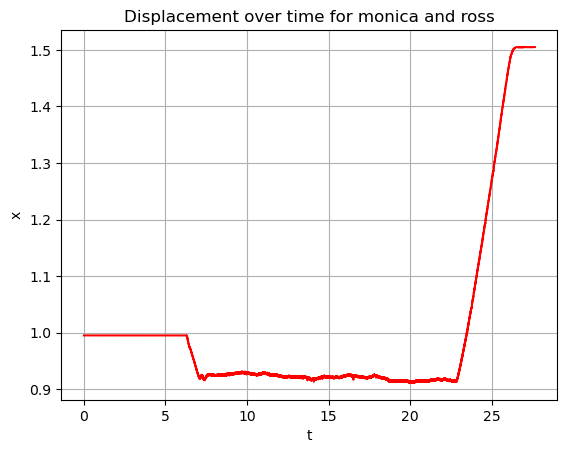

In [235]:
bag_path = Path('../../../datasets/vicon_data/exp_3')

ross_poses = get_pose_data(bag_path, '/world_ross_pose')
monica_poses = get_pose_data(bag_path, '/world_monica_pose')

ross_cmd_vel_data = get_cmd_vel_data(bag_path, '/ross/cmd_vel')
monica_cmd_vel_data = get_cmd_vel_data(bag_path, '/monica/cmd_vel')

clean_data(monica_poses, ross_poses, monica_cmd_vel_data, ross_cmd_vel_data)

plot_displacements_over_time(ross_poses['time_sec'], monica_poses, ross_poses)

In [236]:
monica_poses.head(10)

,index,timestamp,time_sec,position_x,position_y,position_z,orientation_x,orientation_y,orientation_z,orientation_w
0,0,1754946373036862430,0.000000,-0.665603,0.358207,0.249529,0.004311,-0.003488,0.999914,-0.011902
1,1,1754946373036926262,0.000064,-0.665603,0.358207,0.249529,0.004311,-0.003488,0.999914,-0.011902
2,2,1754946373036936040,0.000074,-0.665603,0.358207,0.249529,0.004311,-0.003488,0.999914,-0.011902
3,3,1754946373036945078,0.000083,-0.665603,0.358207,0.249529,0.004311,-0.003488,0.999914,-0.011902
4,4,1754946373036959024,0.000097,-0.665603,0.358207,0.249529,0.004311,-0.003488,0.999914,-0.011902
5,5,1754946373036967841,0.000106,-0.665603,0.358207,0.249529,0.004311,-0.003488,0.999914,-0.011902
6,6,1754946373036976407,0.000114,-0.665597,0.358213,0.249550,0.004290,-0.003317,0.999914,-0.011966
7,7,1754946373036984793,0.000123,-0.665597,0.358213,0.249550,0.004290,-0.003317,0.999914,-0.011966
8,8,1754946373036993149,0.000131,-0.665598,0.358196,0.249499,0.004410,-0.003422,0.999913,-0.011928
9,9,1754946373037002177,0.000140,-0.665598,0.358196,0.249499,0.004410,-0.003422,0.999913,-0.011928


In [237]:
ross_poses.head(10)

,index,timestamp,time_sec,position_x,position_y,position_z,orientation_x,orientation_y,orientation_z,orientation_w
0,0,1754946373036897647,0.000000,-1.660751,0.472422,0.251484,-0.001637,0.002743,0.002140,0.999993
1,1,1754946373036929107,0.000032,-1.660751,0.472422,0.251484,-0.001637,0.002743,0.002140,0.999993
2,2,1754946373036938786,0.000041,-1.660751,0.472422,0.251484,-0.001637,0.002743,0.002140,0.999993
3,3,1754946373036947873,0.000051,-1.660751,0.472422,0.251484,-0.001637,0.002743,0.002140,0.999993
4,4,1754946373036961689,0.000064,-1.660751,0.472422,0.251484,-0.001637,0.002743,0.002140,0.999993
5,5,1754946373036970516,0.000073,-1.660751,0.472422,0.251484,-0.001637,0.002743,0.002140,0.999993
6,6,1754946373036979022,0.000082,-1.660754,0.472412,0.251525,-0.001813,0.003120,0.002218,0.999991
7,7,1754946373036987368,0.000090,-1.660754,0.472412,0.251525,-0.001813,0.003120,0.002218,0.999991
8,8,1754946373036995674,0.000098,-1.660783,0.472404,0.251513,-0.001559,0.003209,0.002151,0.999991
9,9,1754946373037004691,0.000107,-1.660783,0.472404,0.251513,-0.001559,0.003209,0.002151,0.999991


Bag duration: 27.65 seconds
Message count: 60620
Bag duration: 27.65 seconds
Message count: 60620


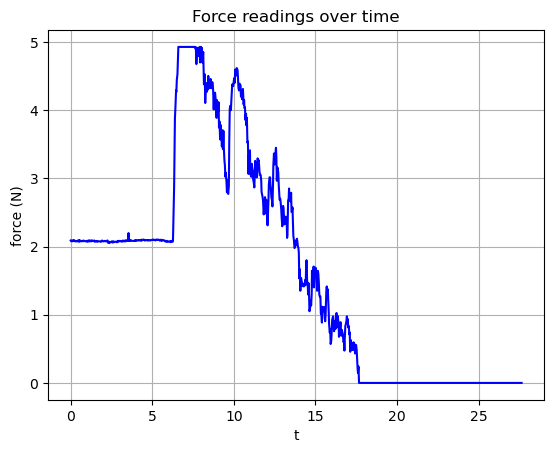

In [238]:
ross_force_data = get_force_data(bag_path, '/ross/force')
monica_force_data = get_force_data(bag_path, '/monica/force')

# clean_data(monica_force_data, ross_force_data, monica_cmd_vel_data, ross_cmd_vel_data)

# plot_force_data(ross_force_data['time_sec'], monica_force_data['data'], ross_force_data['data'])
plot_force_data(ross_force_data['time_sec'], ross_force_data['data'])

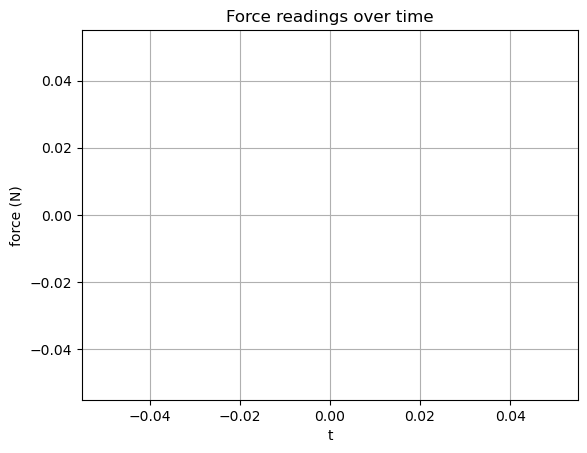

In [239]:
plot_force_data(monica_force_data['time_sec'], monica_force_data['data'])

In [240]:
ross_poses[
    (ross_poses['time_sec'] >= 20.1) &
    (ross_poses['time_sec'] <= 20.15)
]['position_x'].mean() - ross_poses['position_x'].min()

2.5847848057746887